<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Генеративные модели в машинном обучении, МОВС, ФКН ВШЭ</center></h1>
<h2><center>Домашнее задание 3: Диффузия, потоки</center></h2>

# Введение

До заголовка "Диффузионные модели" все по-старому. Только Задания 1-2 теперь неоцениваемые, ведь вы их уже делали

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

    Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.

    По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

    Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

    Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [5]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [6]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [7]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

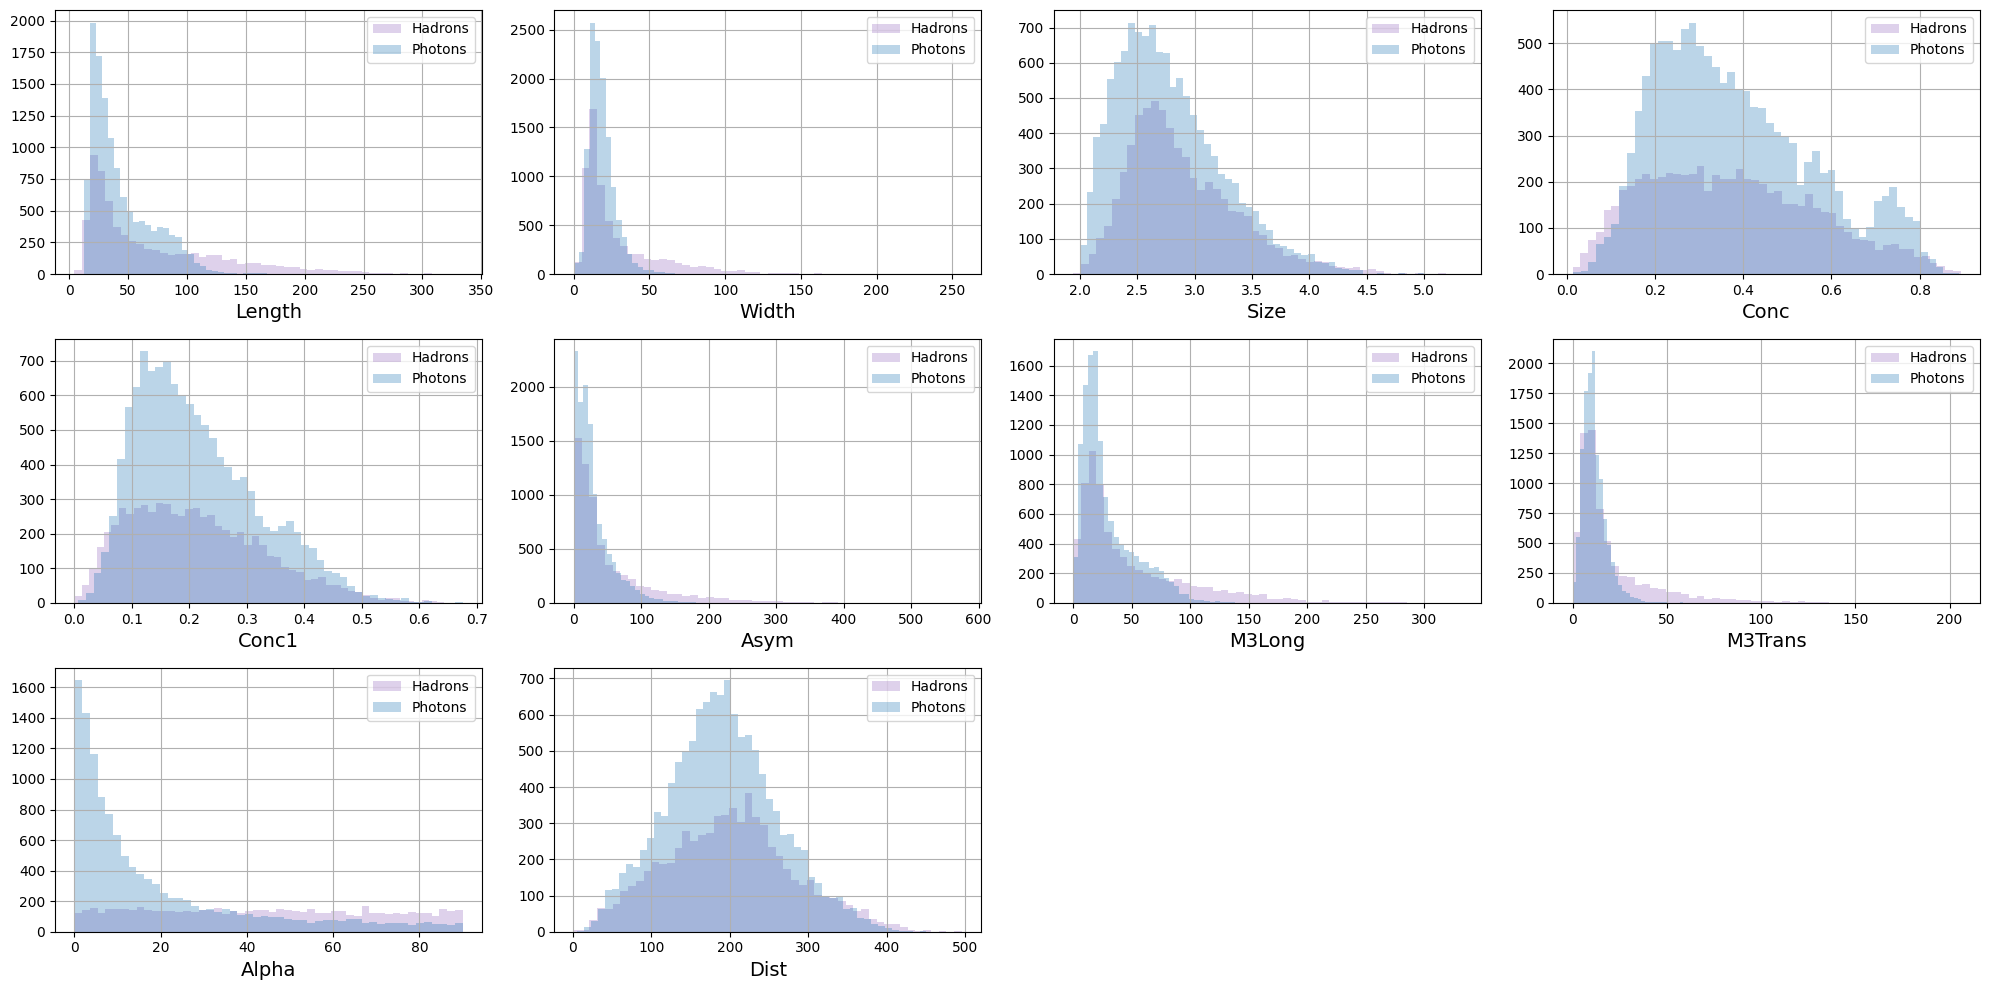

In [9]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [10]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0 баллов)

Проиллюстрируйте распределение y внутри train и test выборки.

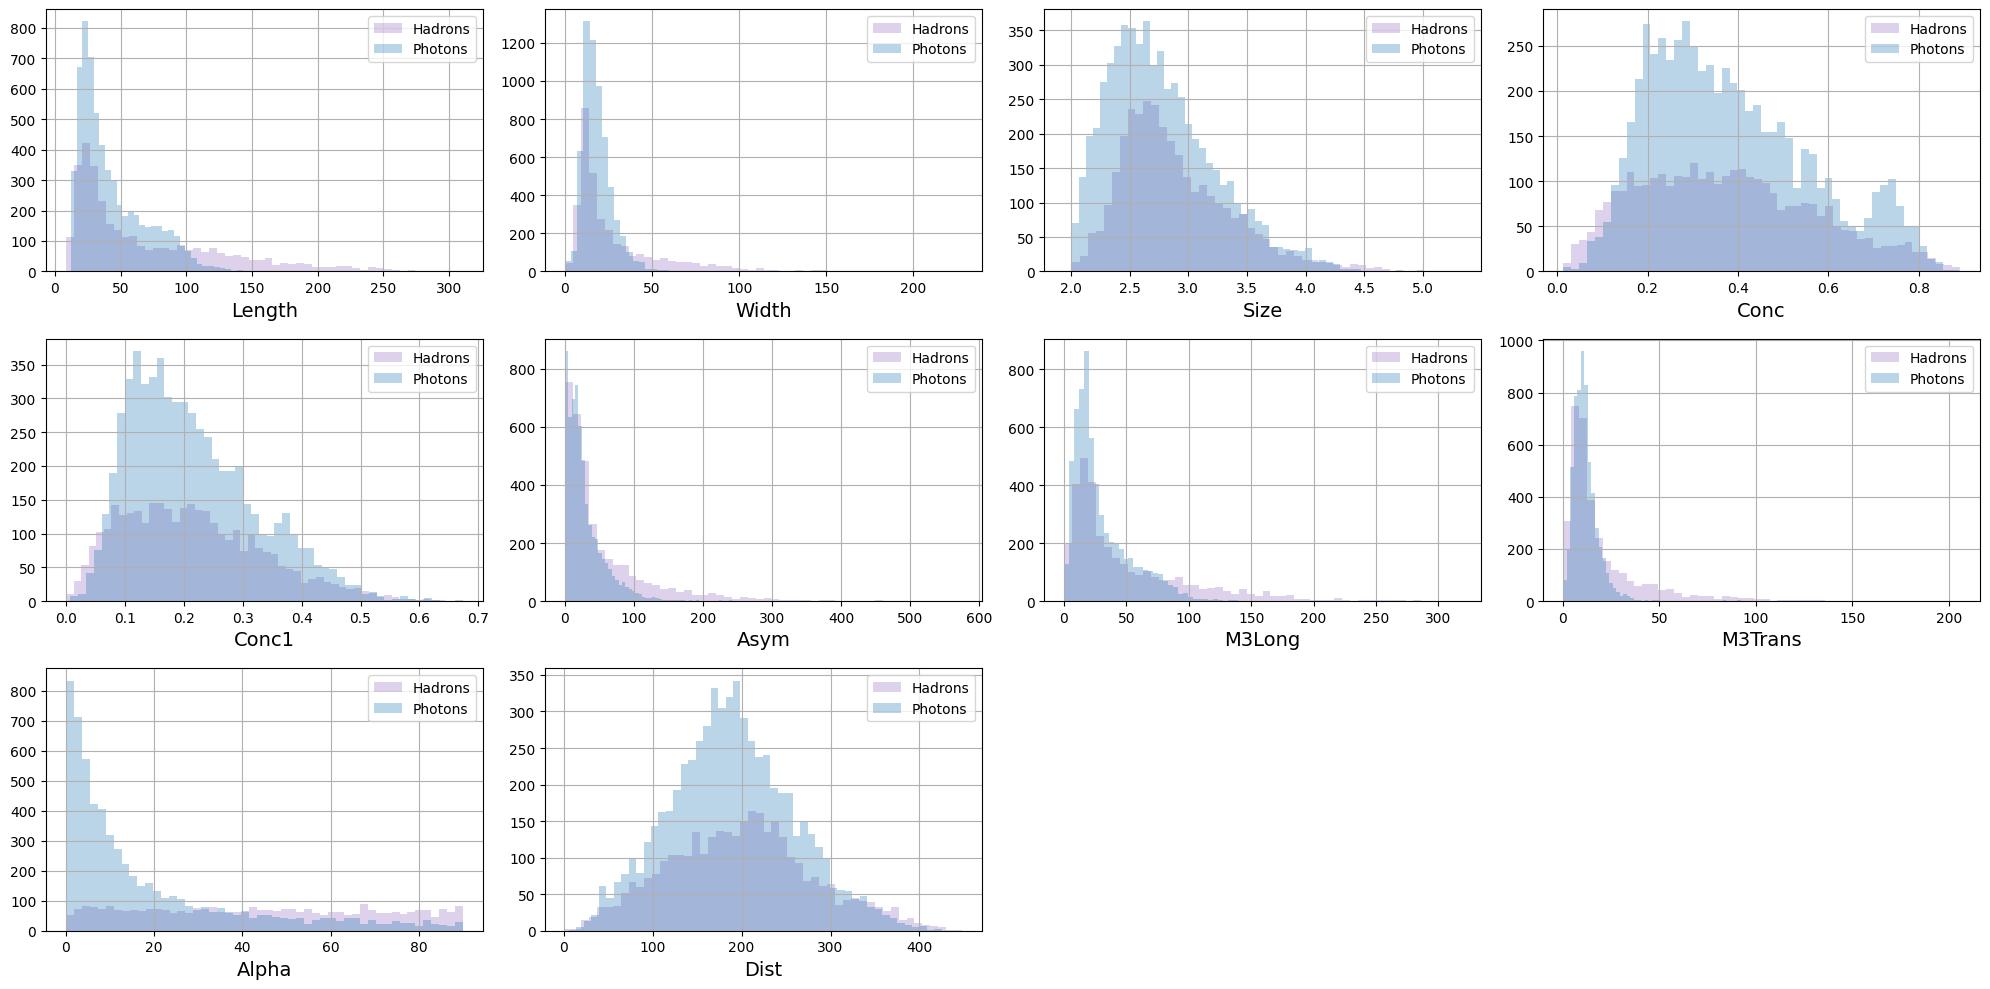

In [11]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names, label1="Hadrons",
    label2="Photons",
    bins=50
)


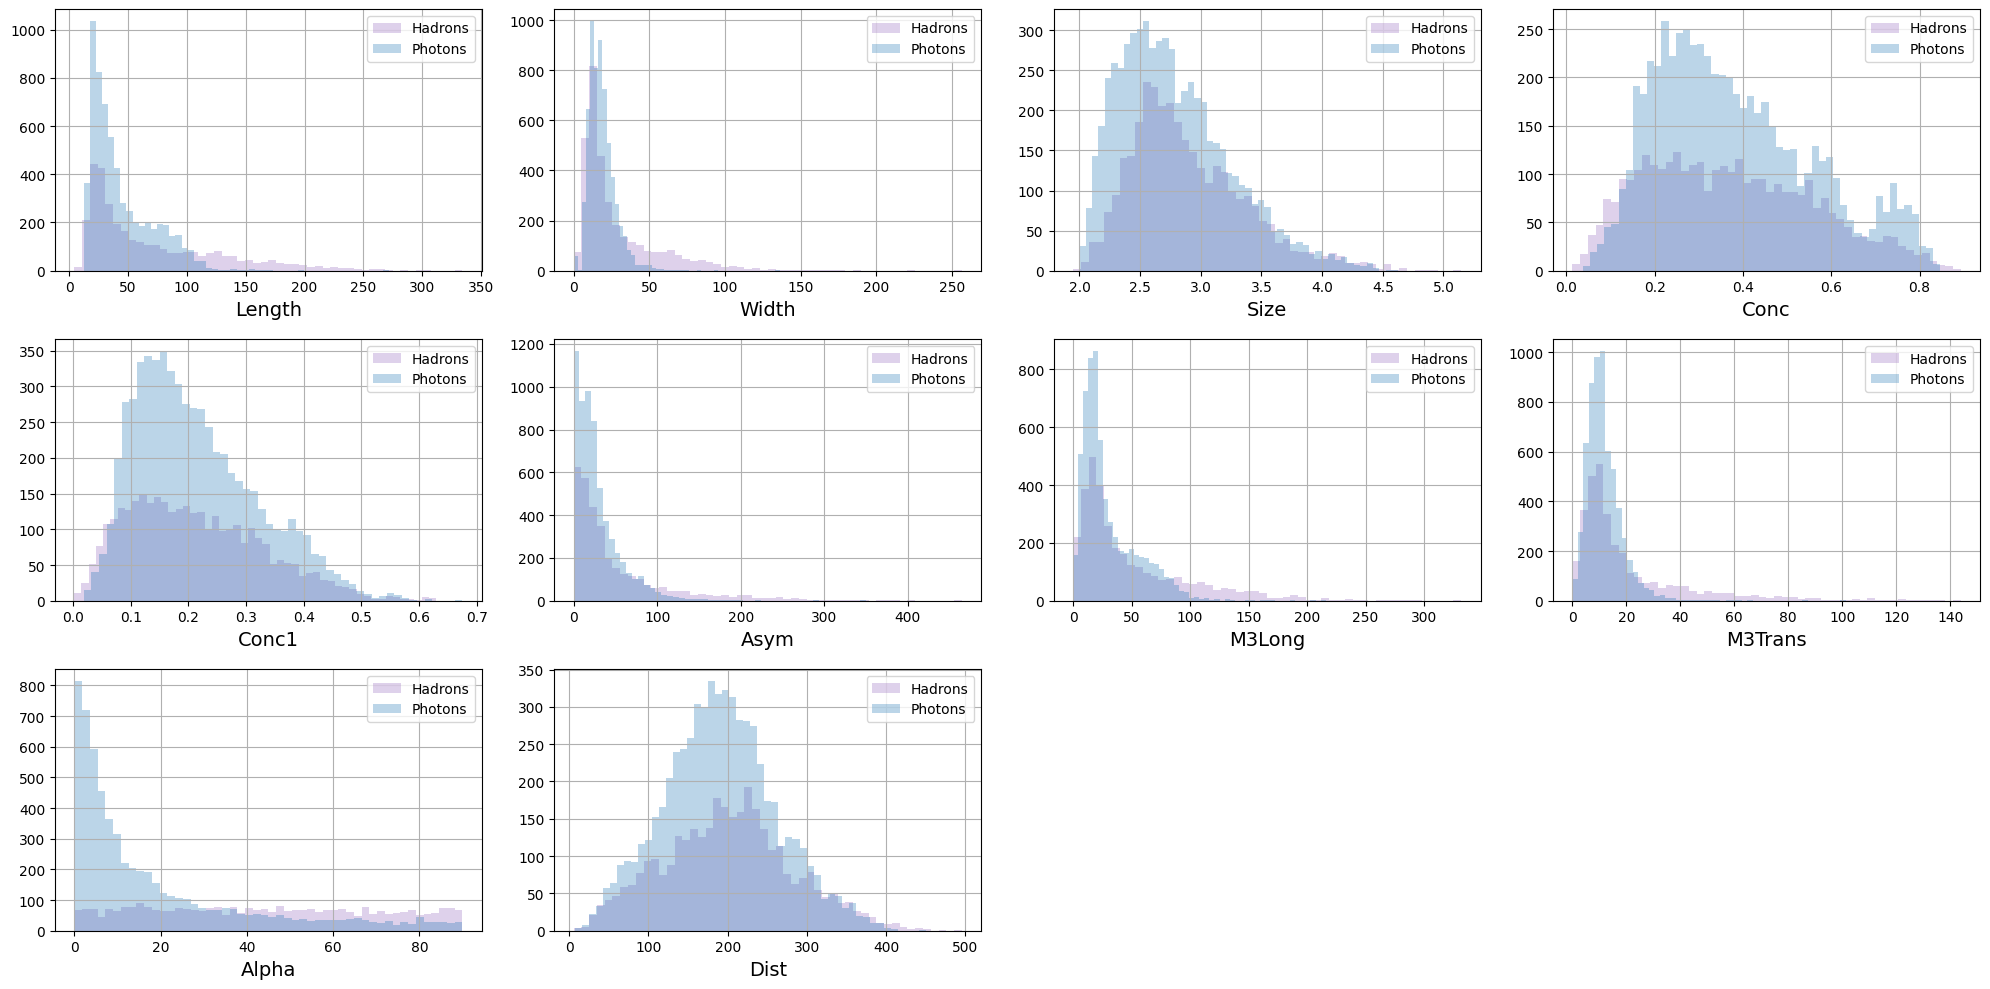

In [12]:
plot_hists(
    X_test[y_test[:, 0] == 0],
    X_test[y_test[:, 0] == 1],
    names, label1="Hadrons",
    label2="Photons",
    bins=50
)

## Задание 2 (0 баллов)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [13]:
### YOUR CODE IS HERE ######
qt = QuantileTransformer(output_distribution='normal', random_state=11)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)
### THE END OF YOUR CODE ###

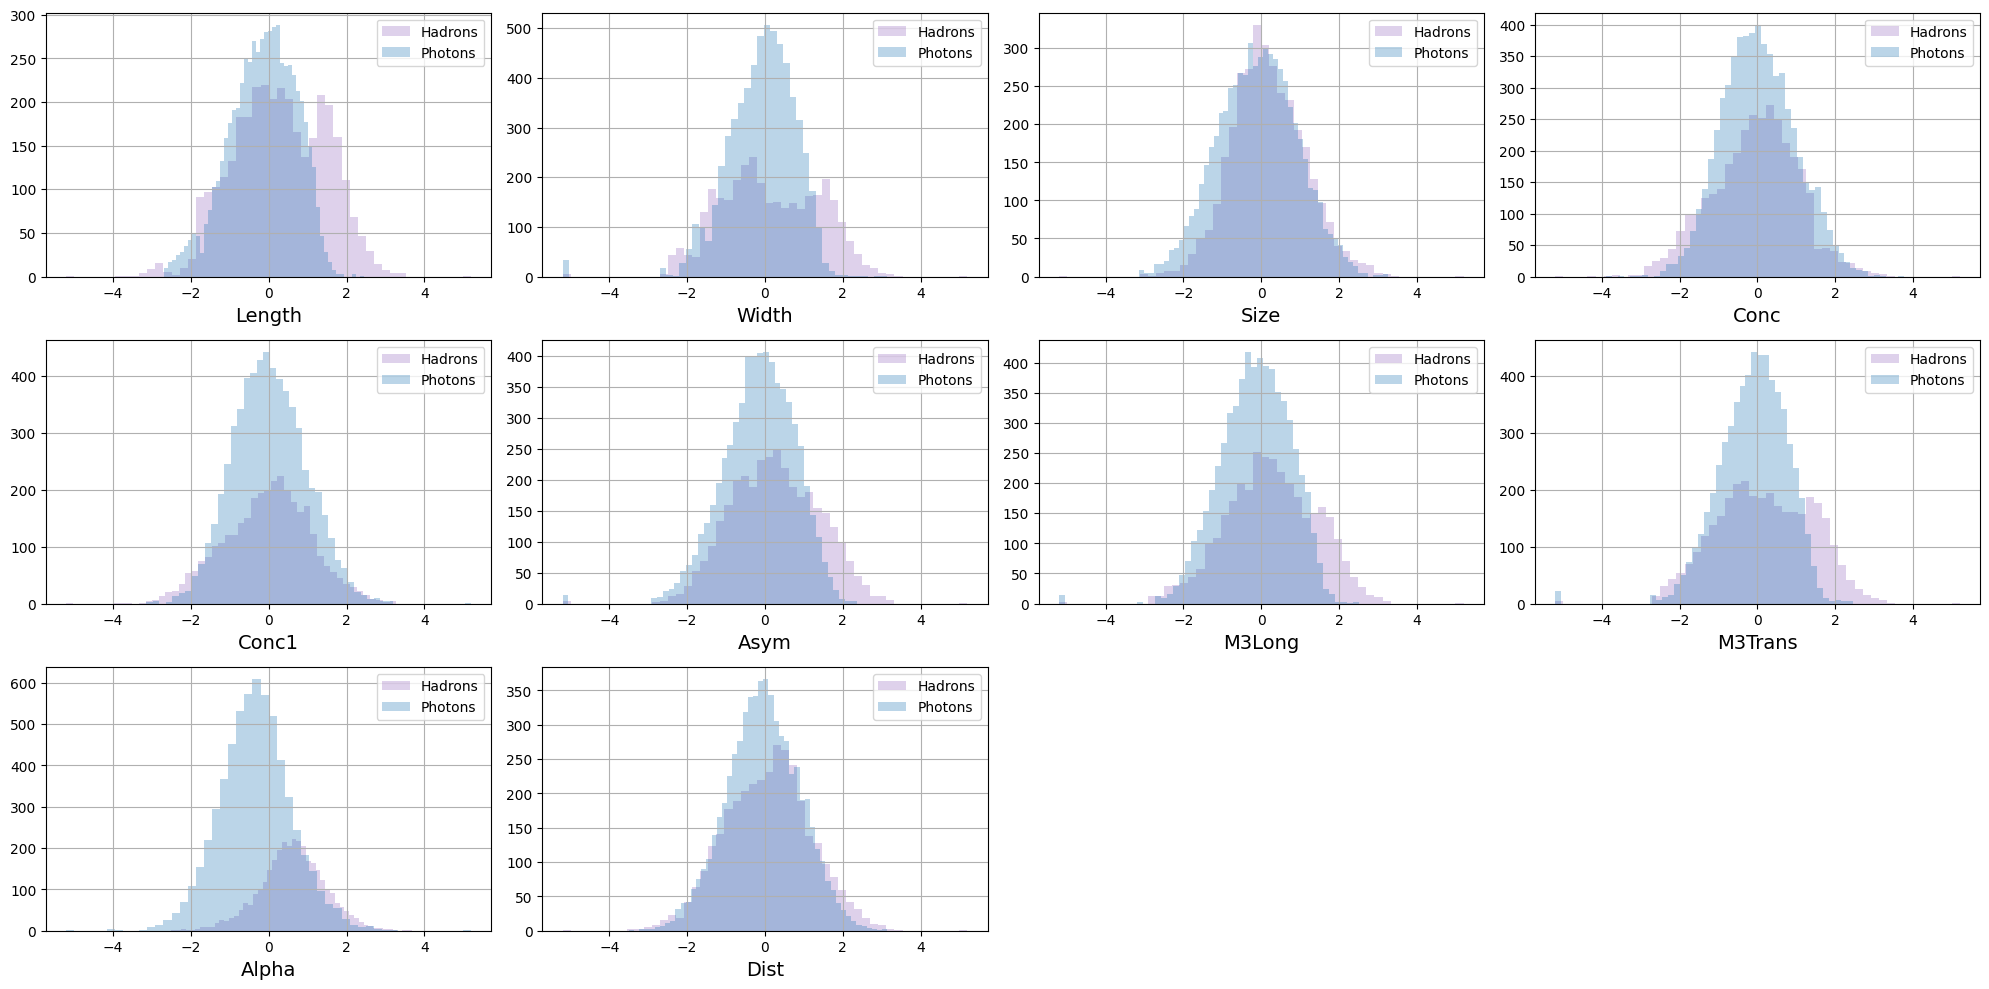

In [14]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

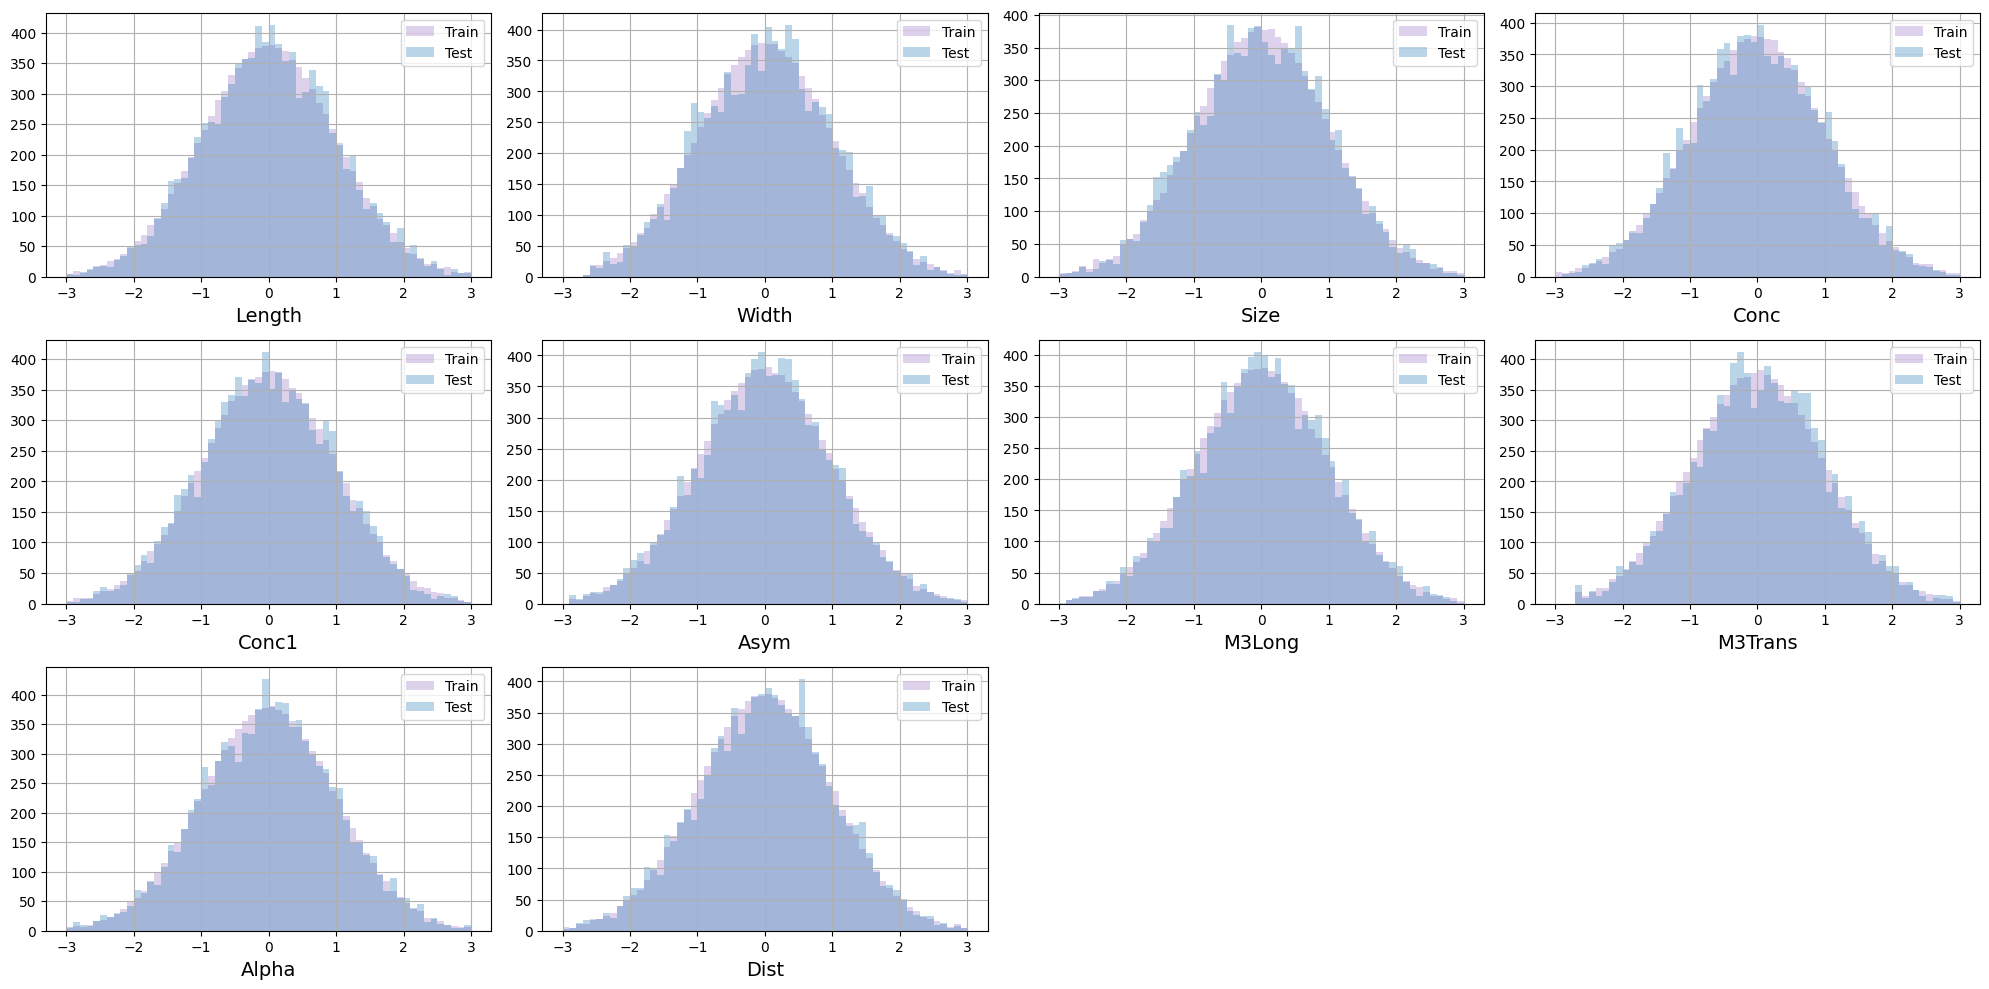

In [15]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Диффузионные модели (4 балла)

Проведем, по большому счету, такой же эксперимент, как в ДЗ-2, с диффузионной моделью.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Задание 3 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [17]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.randn_like(x)
    amount = amount.view(-1, 1)
    x = x * (1 - amount) + noise * amount
    ### THE END OF YOUR CODE ###
    return x

Добавим sсheduler, он пригодится вам при обучении модели.

*Советуем вниматиельно почитать доку по шедулеру.*

In [18]:
from diffusers import DDPMScheduler

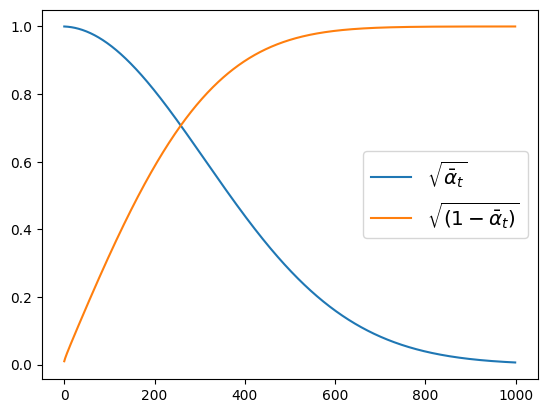

In [19]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 4 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [20]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
          nn.Linear(n_inputs, 100),
          nn.BatchNorm1d(100),
          nn.ReLU(True),

          nn.Linear(100, 100),
          nn.BatchNorm1d(100),
          nn.ReLU(True),

          nn.Linear(100, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 5 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [21]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    model.eval()

    y = torch.tensor(y, dtype=torch.long).to(next(model.parameters()).device)

    y_onehot = F.one_hot(y, num_classes=2).float()
    z = torch.randn(y.size(0), latent_dim, device=y.device)
    with torch.no_grad():
        X_fake = model(z, y_onehot)

    return X_fake.cpu().numpy()

## Задание 6 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [23]:
def other_agent_score(X, y_binary):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary,
        test_size=0.25,
        stratify=y_binary,
        random_state=42
    )

    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_acc = accuracy_score(y_test, lr_pred)

    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)
    gb_pred = gb.predict(X_test)
    gb_acc = accuracy_score(y_test, gb_pred)

    return {
        'lr_acc': lr_acc,
        'gb_acc': gb_acc
    }

In [24]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                noise_amount = torch.rand(real_batch.size(0), device=DEVICE)
                x_nois = corrupt(real_batch, noise_amount)

                x_pred = self.model(x_nois, cond_batch)
                loss = F.mse_loss(x_pred, real_batch)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            idx_real = torch.randperm(len(X_real))[:1000]
            X_real_sample = X_real[idx_real]
            y_real_sample = y_cond[idx_real]

            num = 1000
            y_gen_labels = torch.cat([
                torch.zeros(num // 2, 1, device=DEVICE),
                torch.ones(num // 2, 1, device=DEVICE)
            ])
            z_noise = torch.randn(num, self.latent_dim, device=DEVICE)

            with torch.no_grad():
                X_fake = self.model(z_noise, y_gen_labels)

            X_comb = torch.cat([X_real_sample, X_fake], dim=0).cpu().numpy()
            y_labels_comb = torch.cat([
                torch.zeros(len(X_real_sample)),
                torch.ones(len(X_fake))
            ]).cpu().numpy()

            score = other_agent_score(X_comb, y_labels_comb)
            print(f"Epoch {epoch+1}: lr_acc score = {score['lr_acc']:.5f}")
            print(f"Epoch {epoch+1}: gb_acc score = {score['gb_acc']:.5f}")
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [25]:
y.shape[1]

1

In [26]:
X_train.shape[1]

10

In [27]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Epoch 1: lr_acc score = 0.49600
Epoch 1: gb_acc score = 0.88000
Epoch 2: lr_acc score = 0.52600
Epoch 2: gb_acc score = 0.84600
Epoch 3: lr_acc score = 0.50600
Epoch 3: gb_acc score = 0.82200
Epoch 4: lr_acc score = 0.54000
Epoch 4: gb_acc score = 0.77600
Epoch 5: lr_acc score = 0.47600
Epoch 5: gb_acc score = 0.80000
Epoch 6: lr_acc score = 0.51800
Epoch 6: gb_acc score = 0.80200
Epoch 7: lr_acc score = 0.50600
Epoch 7: gb_acc score = 0.78200
Epoch 8: lr_acc score = 0.52000
Epoch 8: gb_acc score = 0.80200
Epoch 9: lr_acc score = 0.57800
Epoch 9: gb_acc score = 0.80200
Epoch 10: lr_acc score = 0.51600
Epoch 10: gb_acc score = 0.78400
Epoch 11: lr_acc score = 0.47800
Epoch 11: gb_acc score = 0.82600
Epoch 12: lr_acc score = 0.53600
Epoch 12: gb_acc score = 0.80800
Epoch 13: lr_acc score = 0.50600
Epoch 13: gb_acc score = 0.80200
Epoch 14: lr_acc score = 0.52200
Epoch 14: gb_acc score = 0.78000
Epoch 15: lr_acc score = 0.52400
Epoch 15: gb_acc score = 0.77400
Epoch 16: lr_acc score = 0.5

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

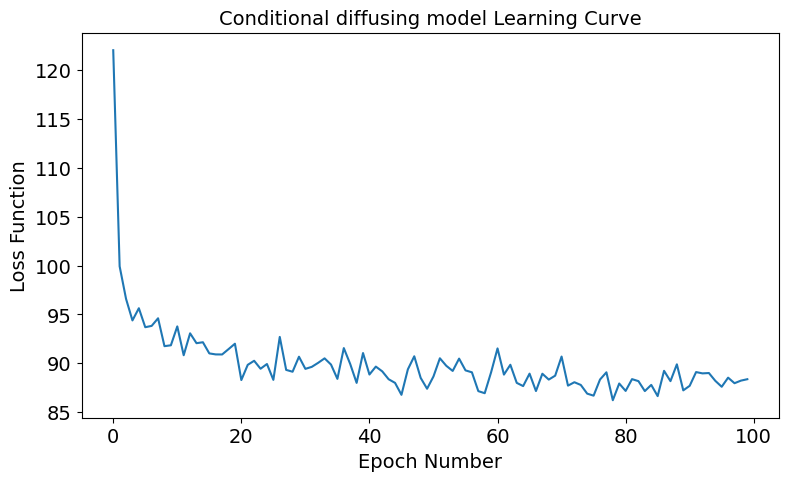

In [28]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 7 (0.5 балла)
По аналогии с прошлым экспериментом (из ДЗ-2) с GAN моделью сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с сWGAN моделью?

In [29]:
import torch.nn.functional as F

n_gamma_real = int((y_test == 1).sum())
n_hadron_real = int((y_test == 0).sum())
print(f"Real test: {n_hadron_real} hadrons, {n_gamma_real} gammas")

model.eval()
with torch.no_grad():
    z0 = torch.randn(n_hadron_real, latent_dim, device=DEVICE)
    y0 = torch.zeros(n_hadron_real, 1, device=DEVICE)
    X_fake_h = model(z0, y0)

    z1 = torch.randn(n_gamma_real, latent_dim, device=DEVICE)
    y1 = torch.ones(n_gamma_real, 1, device=DEVICE)
    X_fake_g = model(z1, y1)

    X_fake = torch.cat([X_fake_h, X_fake_g], dim=0).cpu().numpy()
    y_fake_labels = np.ones(len(X_fake))

X_real_test = X_test
y_real_labels = np.zeros(len(X_real_test))

X_combined = np.vstack([X_real_test, X_fake])
y_combined = np.hstack([y_real_labels, y_fake_labels])
print("Combined dataset shape:", X_combined.shape)

Real test: 3344 hadrons, 6166 gammas
Combined dataset shape: (19020, 10)


In [30]:
def count_rocauc_accuracy(X, y):
  X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
  )
  estimators = 200
  gb = GradientBoostingClassifier(
    n_estimators=estimators,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
  )
  gb.fit(X_tr, y_tr)

  y_pred_proba = gb.predict_proba(X_te)[:, 1]
  y_pred = gb.predict(X_te)

  roc_auc = roc_auc_score(y_te, y_pred_proba)
  acc = accuracy_score(y_te, y_pred)
  print(f"results:")
  print(f"   ROC-AUC: {roc_auc:.4f}")
  print(f"   Accuracy: {acc:.4f}")

In [31]:
count_rocauc_accuracy(X_combined, y_combined)

results:
   ROC-AUC: 0.9587
   Accuracy: 0.8913


# Потоки (4 балла)

## Задание 8 (1.5 балла)

Диффузия показала себя как достойный конкурент GAN модели. Так как данных не много, обучали не долго, задача не сложная - отличия от GAN не так заметны, но все равно достойные.

Для Diffusion получили ROC AUC около 0.73 (меньше лучше). Попробуем обучить RealNVP для решения этой задачи.

**Дополните базовый класс для нормализационного необходимым.**

<center><img src="img/mem1.jpg" width="500"></center>

<center><img src="img/mem2.jpg" width="500"></center>

In [32]:
print("X_train.shape =", X_train.shape)

X_train.shape = (9510, 10)


In [33]:
X_train_tensor = torch.from_numpy(X_train).float()
trainloader = torch.utils.data.DataLoader(
    X_train_tensor, batch_size=64, shuffle=True
)

In [34]:
# Main class for NormFlow
class NormalizingFlow(nn.Module):

    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()

        # your code below
        self.layers = nn.ModuleList(layers)
        self.prior = prior

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = log_likelihood + change
            else:
                log_likelihood = change

        log_likelihood = log_likelihood + self.prior.log_prob(x)

        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples, ))

        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

## Задание 9 (2 балла)

Реализуйте нейронную сеть RealNVP. Возьмите для прямого и обратного преобразования нейронную сеть (функцию) со следующими параметрами:

- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [35]:
import torch.nn as nn

class RealNVP(nn.Module):
    def __init__(self, var_size, mask, hidden=100):
        super(RealNVP, self).__init__()
        self.mask = mask  # вам это может не понадобиться. Восприниматйте как подсказку
        self.var_size = var_size

        self.nn_t = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size)
        )
        self.nn_s = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size)
        )

    def f(self, x):
        x_masked = x * self.mask
        t = self.nn_t(x_masked)
        s = self.nn_s(x_masked)
        s = torch.tanh(s) * 2

        new_x = x * torch.exp(self.mask * 0 + (1 - self.mask) * s) + (1 - self.mask) * t
        log_det = ((1 - self.mask) * s).sum(dim=1)

        return new_x, log_det

    def g(self, x):
        z_masked = x * self.mask
        t = self.nn_t(z_masked)
        s = self.nn_s(z_masked)
        s = torch.tanh(s) * 2

        new_x = self.mask * x + (1 - self.mask) * (x - t) * torch.exp(-s)
        return new_x

In [36]:
def train_nf(tr_dataloader, nf, opt, num_epochs):
    nf.train()
    loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            x = batch.float()

            opt.zero_grad()

            loss = -nf.log_prob(x)

            loss.backward()
            opt.step()
            loss_trace.append((iter_i, loss.item()))

            iter_i += 1

In [37]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10), torch.eye(10))

layers = []
for i in range(4):
    mask = ((torch.arange(10) + i) % 2).float()
    layers.append(RealNVP(var_size=10, mask=mask))

nf = NormalizingFlow(layers=layers,
                    prior=prior)

opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

In [38]:
train_nf(trainloader, nf, opt, num_epochs=10)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


## Задание 10 (0.5 балла)

По аналогии с прошлым экспериментом с диффузией сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с остальными моделями?

In [41]:
from sklearn.ensemble import RandomForestClassifier

n_test = X_test.shape[0]
n_gamma_real = int((y_test == 1).sum())
n_hadron_real = int((y_test == 0).sum())

print(f"Real test split: {n_hadron_real} hadrons, {n_gamma_real} gammas")


nf.eval()
with torch.no_grad():
    X_fake_large = nf.sample(2 * n_test).cpu().numpy()

clf_bal = RandomForestClassifier(n_estimators=50, random_state=42)
clf_bal.fit(X_train, y_train.squeeze())

y_fake_pred = clf_bal.predict(X_fake_large)
proba_fake = clf_bal.predict_proba(X_fake_large)[:, 1]

idx_h = np.where(y_fake_pred == 0)[0][:n_hadron_real]
idx_g = np.where(y_fake_pred == 1)[0][:n_gamma_real]

X_fake = np.vstack([X_fake_large[idx_h], X_fake_large[idx_g]])
print(f"Fake sample: {len(idx_h)} hadrons, {len(idx_g)} gammas")

X_combined = np.vstack([X_test, X_fake])
y_c2st = np.hstack([np.zeros(len(X_test)), np.ones(len(X_fake))])

Real test split: 3344 hadrons, 6166 gammas
Fake sample: 3344 hadrons, 6166 gammas


In [40]:
count_rocauc_accuracy(X_combined, y_c2st)

results:
   ROC-AUC: 0.6676
   Accuracy: 0.6181


# Улучшения (1+ балл)

Попробуйте настроить параметры обучения какой-нибудь модели или еще как-нибудь их улучшить, чтобы получить как можно меньший ROC AUC. Что получилось? Какая модель лучше?

Ставим 0.1 балл за каждую сотую скора сверх (сниз) ROC-AUC=0.65 невключительно. Т.е. за 0.65 получаете 0, за 0.649 -- 0.1, 0.639 -- 0.2, 0.609 -- 0.5, 0.559 -- 1

In [ ]:
# your code here


# (*) Аналитика (1 балл)

***Убедительно* подвтердите или опровергните гипотезу "Синтетические данные НЕ помогают лучше классифицировать частицы из исходного датасета."**

Здесь от вас ожидается что-то в духе аналитической записки. Приветствуются графики и прочие "умные вещи". На максимальный балл это весьма объемное задание.